In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, confusion_matrix
from lifelines import CoxPHFitter
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

In [2]:
df = pd.read_csv("./churn_dataset.csv")

In [3]:
def data_processing(df):
    df = df.copy()
    for col in ["Partner", "Dependents", "PhoneService", "PaperlessBilling", "Churn"]:
        df[col] = df[col].map({"No": 0, "Yes": 1})
    for col in ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]:
        df[col] = df[col].map({"No": 0, "No internet service": 0, "Yes": 1})
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].str.replace(" ", "0.0"))
    df['MultipleLines'] = df['MultipleLines'].map({"No": 0, "No phone service": 0, "Yes": 1})
    df = pd.get_dummies(df.drop(["customerID"], axis=1), drop_first=True)
    return df

In [4]:
train_df = data_processing(df)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          7043 non-null   int64  
 1   Partner                                7043 non-null   int64  
 2   Dependents                             7043 non-null   int64  
 3   tenure                                 7043 non-null   int64  
 4   PhoneService                           7043 non-null   int64  
 5   MultipleLines                          7043 non-null   int64  
 6   OnlineSecurity                         7043 non-null   int64  
 7   OnlineBackup                           7043 non-null   int64  
 8   DeviceProtection                       7043 non-null   int64  
 9   TechSupport                            7043 non-null   int64  
 10  StreamingTV                            7043 non-null   int64  
 11  Stre

In [5]:
X = train_df.drop("Churn", axis=1)
y = train_df["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(f"{X_train.shape=}, {y_train.shape=}, {X_test.shape=}, {y_test.shape=}")

X_train.shape=(5634, 23), y_train.shape=(5634,), X_test.shape=(1409, 23), y_test.shape=(1409,)


### Classification

In [6]:
lr = LogisticRegression(max_iter=50000)
scores = cross_val_score(lr, X_train, y_train, cv=5, scoring="f1")
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(f"Model f1 score on Train Dataset: {scores.mean()}")
print(f"Model f1 score on Test Dataset: {f1_score(y_test, y_pred)}")

Model f1 score on Train Dataset: 0.6014061730376815
Model f1 score on Test Dataset: 0.5821325648414986


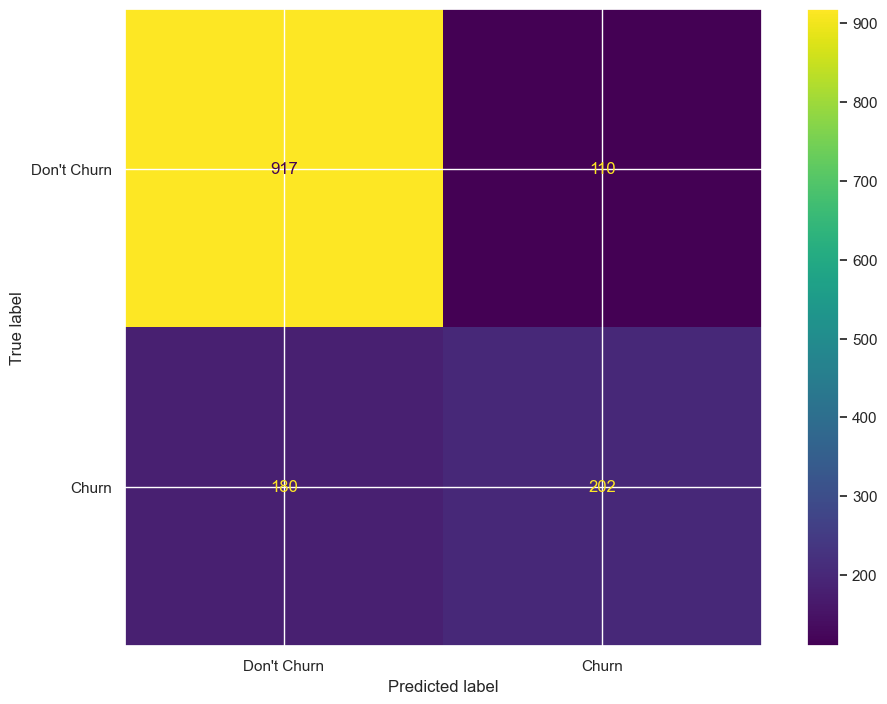

In [7]:
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm).from_predictions(y_test, y_pred, display_labels=["Don't Churn", "Churn"])
plt.show()

In [8]:
rf = RandomForestClassifier(n_estimators=500,max_depth=10, min_samples_split=2, n_jobs=-1)
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring="f1")
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f"Model f1 score on Train Dataset: {scores.mean()}")
print(f"Model f1 score on Test Dataset: {f1_score(y_test, y_pred)}")

Model f1 score on Train Dataset: 0.5850420546422062
Model f1 score on Test Dataset: 0.5565749235474006


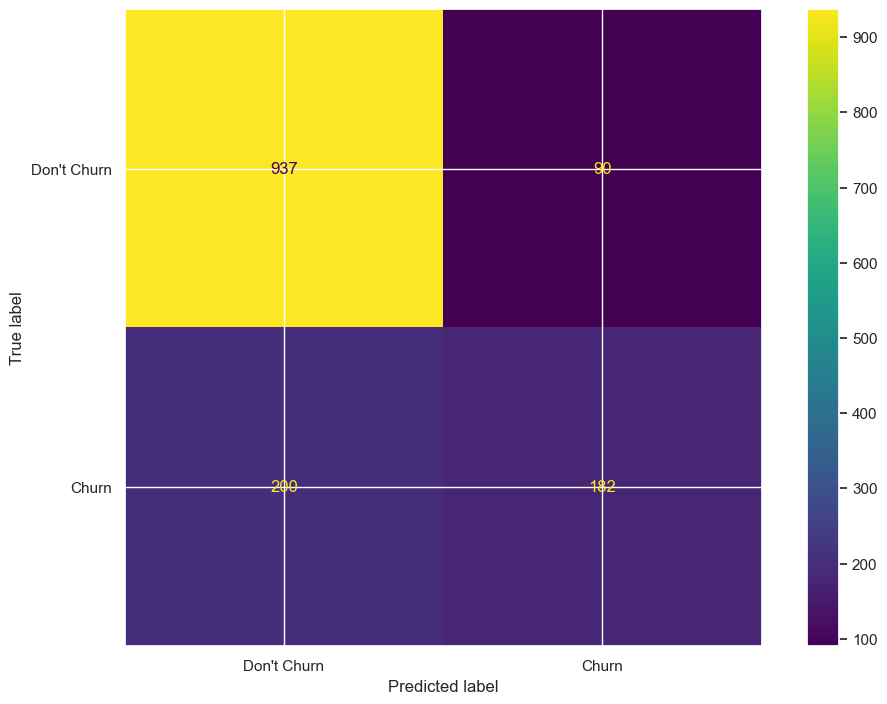

In [9]:
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm).from_predictions(y_test, y_pred, display_labels=["Don't Churn", "Churn"])
plt.show()

In [10]:
svc = SVC(C=1.0, kernel='rbf', class_weight='balanced')
scores = cross_val_score(svc, X_train, y_train, cv=5, scoring="f1")
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(f"Model f1 score on Train Dataset: {scores.mean()}")
print(f"Model f1 score on Test Dataset: {f1_score(y_test, y_pred)}")

Model f1 score on Train Dataset: 0.4646912132567637
Model f1 score on Test Dataset: 0.4764044943820225


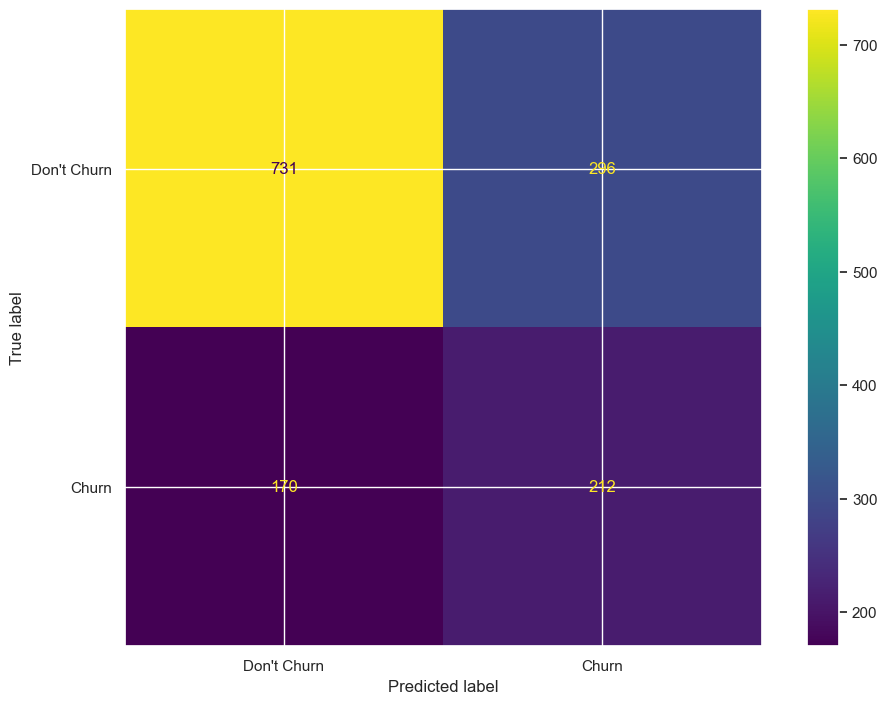

In [11]:
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm).from_predictions(y_test, y_pred, display_labels=["Don't Churn", "Churn"])
plt.show()

### Survival Analysis

In [12]:
cph = CoxPHFitter()
cph.fit(train_df, duration_col='tenure', event_col='Churn')

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -12659.69
         time fit was run = 2025-06-18 18:32:23 UTC

---
                                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                              
SeniorCitizen                          0.03      1.04      0.06           -0.08            0.15                0.93                1.16
Partner                               -0.18      0.84      0.06           -0.29           -0.07                0.75                0.93
Dependents                            -0.09      0.91      0.07           -0.23            0.05                0.80                1.05
PhoneService                           0.83      2.29      0.47           -0.10            1.76                0.90                5.80
MultipleLines                          0.09      1.09      0.13           -0.16            0.33                0.85                1.40
OnlineSecurity                        -0.21      0.81      0.13           -0.47            0.05                0.62                1.05
OnlineBackup                          -0.06      0.95      0.13           -0.31            0.19                0.74                1.21
DeviceProtection                       0.09      1.09      0.13           -0.16            0.34                0.85                1.40
TechSupport                           -0.08      0.92      0.13           -0.34            0.17                0.71                1.19
StreamingTV                            0.28      1.32      0.24           -0.18            0.74                0.83                2.10
StreamingMovies                        0.29      1.33      0.24           -0.18            0.75                0.84                2.11
PaperlessBilling                       0.15      1.16      0.06            0.04            0.26                1.04                1.30
MonthlyCharges                         0.01      1.01      0.02           -0.03            0.06                0.97                1.06
TotalCharges                          -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
gender_Male                           -0.04      0.96      0.05           -0.13            0.05                0.88                1.05
InternetService_Fiber optic            1.02      2.77      0.58           -0.12            2.15                0.89                8.59
InternetService_No                    -2.34      0.10      0.60           -3.51           -1.17                0.03                0.31
Contract_One year                     -1.27      0.28      0.10           -1.46           -1.07                0.23                0.34
Contract_Two year                     -3.70      0.02      0.20           -4.10           -3.31                0.02                0.04
PaymentMethod_Credit card (automatic) -0.01      0.99      0.09           -0.19            0.17                0.83                1.18
PaymentMethod_Electronic check         0.39      1.47      0.07            0.24            0.53                1.28                1.70
PaymentMethod_Mailed check             0.51      1.67      0.09            0.34            0.68                1.40                1.98

                                       cmp to      z      p  -log2(p)
covariate                                                            
SeniorCitizen                            0.00   0.61   0.54      0.88
Partner                                  0.00  -3.23 <0.005      9.67
Dependents                               0.00  -1.31   0.19      2.40
PhoneService        

To Be Continued